In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from scipy.stats import norm

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import f1_score

In [2]:
df_train = pd.read_pickle('../input/ion-switching-preprocessing/train.pkl')
df_test = pd.read_pickle('../input/ion-switching-preprocessing/test.pkl')

print('Training Set Shape = {}'.format(df_train.shape))
print('Training Set Memory Usage = {:.2f} MB'.format(df_train.memory_usage().sum() / 1024 ** 2))
print('Test Set Shape = {}'.format(df_test.shape))
print('Test Set Memory Usage = {:.2f} MB'.format(df_test.memory_usage().sum() / 1024 ** 2))

Training Set Shape = (5000000, 10)
Training Set Memory Usage = 219.35 MB
Test Set Shape = (2000000, 8)
Test Set Memory Usage = 70.57 MB


In [3]:
class ViterbiClassifier:
    
    def __init__(self):
        self.probability_transition = None
        self.probability_signal = None
        
    def fit(self, X, y):
        self.unique_states = np.unique(y)
        self.n_states = len(self.unique_states)        
        self.probability_transition = self.markov_probability_transition(y)
                
        self.distances = []
        for state in np.arange(y.min(), y.max() + 1):
            self.distances.append((np.mean(X[y == state]), np.std(X[y == state])))
            
        return self
    
    def predict(self, X, probability_signal=None):
        if probability_signal is None:
            probability_signal = self.markov_probability_signal(X)
            
        predictions, probabilities = self.viterbi(self.probability_transition, probability_signal[self.unique_states], X)

        return probabilities, predictions
        
    def markov_probability_transition(self, y):
        max_openchannels = np.max(y)
        shifted_y = np.roll(y, -1)
        probability_matrix = []
        
        for i in range(max_openchannels + 1):
            current_row = np.histogram(shifted_y[y == i], bins=np.arange(max_openchannels + 2))[0]
            if np.sum(current_row) == 0:
                current_row = np.ones(max_openchannels + 1) / (max_openchannels + 1)
            else:
                current_row = current_row / np.sum(current_row)
            probability_matrix.append(current_row)
        return np.array(probability_matrix)   
    
    def markov_probability_signal(self, X):
        probability_signal = np.zeros((self.n_states, len(X)))
        
        for idx, distance in enumerate(self.distances):
            probability_signal[idx, :] = norm.pdf(X, *distance)
            
        return probability_signal  

    def viterbi(self, probability_transition, probability_signal, X):
        
        offset = 10 ** (-20)

        probability_transition_log_transposed  = np.transpose(np.log2(probability_transition  + offset))
        probability_signal_log_transposed = np.transpose(np.log2(probability_signal + offset)) 
        
        T1 = np.zeros(probability_signal.shape)
        T2 = np.zeros(probability_signal.shape)

        T1[:, 0] = probability_signal_log_transposed[0, :]
        T2[:, 0] = 0

        for j in range(1, probability_signal.shape[1]):
            for i in range(len(probability_transition)):
                T1[i, j] = np.max(T1[:, j - 1] + probability_transition_log_transposed[:, i] + probability_signal_log_transposed[j, i])
                T2[i, j] = np.argmax(T1[:, j - 1] + probability_transition_log_transposed[:, i] + probability_signal_log_transposed[j, i])
        
        x = np.empty(probability_signal.shape[1], 'B')
        x[-1] = np.argmax(T1[:, probability_signal.shape[1] - 1])
        
        for i in reversed(range(1, probability_signal.shape[1])):
            x[i - 1] = T2[x[i], i]
    
        return x, T1  
    
    
class BidirectionalViterbiClassifier:

    def __init__(self):
        self.probability_transition = None
        self.probability_signal = None

    def fit(self, X, y):
        self.unique_states = np.unique(y)
        self.n_states = len(self.unique_states)

        self.distances = []
        for state in np.arange(y.min(), y.max() + 1):
            self.distances.append((np.mean(X[y == state]), np.std(X[y == state])))

        self.probability_transition = self.markov_probability_transition(y)
        
        return self

    def predict(self, x, probability_signal=None, proba=False):
        if probability_signal is None:
            probability_signal = self.markov_probability_signal(x)
            
        predictions = self.posterior_decoding(self.probability_transition, probability_signal[self.unique_states])
        return predictions

    def markov_probability_transition(self, y):
        max_openchannels = np.max(y)
        shifted_y = np.roll(y, -1)
        probability_matrix = []

        for i in range(max_openchannels + 1):
            current_row = np.histogram(shifted_y[y == i], bins=np.arange(max_openchannels + 2))[0]
            if np.sum(current_row) == 0:
                current_row = np.ones(max_openchannels + 1) / (max_openchannels + 1)
            else:
                current_row = current_row / np.sum(current_row)
            probability_matrix.append(current_row)
        return np.array(probability_matrix)   

    def markov_probability_signal(self, X):
        probability_signal = np.zeros((self.n_states, len(X)))

        for idx, distance in enumerate(self.distances):
            probability_signal[idx, :] = norm.pdf(X, *distance)

        return probability_signal 

    def forward(self, probability_transition, probability_signal):

        T1 = np.zeros(probability_signal.shape)
        T1[:, 0] = probability_signal[:, 0]
        T1[:, 0] /= np.sum(T1[:, 0])

        for j in range(1, probability_signal.shape[1]):
            for i in range(len(probability_transition)):
                T1[i, j] = probability_signal[i, j] * np.sum(T1[:, j - 1] * probability_transition[i, :])
            T1[:, j] /= np.sum(T1[:, j])

        return T1

    def backward(self, probability_transition, probability_signal):

        T1 = np.zeros(probability_signal.shape)
        T1[:, -1] = probability_signal[:, -1]
        T1[:, -1] /= np.sum(T1[:, -1])

        for j in range(probability_signal.shape[1] - 2, -1, -1):
            for i in range(len(probability_transition)):
                T1[i, j] = np.sum(T1[:, j + 1] * probability_transition[:, i] * probability_signal[:, j + 1])
            T1[:, j] /= np.sum(T1[:, j])

        return T1

    def posterior_decoding(self, probability_transition, probability_signal):
        fwd = self.forward(probability_transition, probability_signal)
        bwd = self.backward(probability_transition, probability_signal)

        x = np.empty(probability_signal.shape[1], 'B')
        for i in range(probability_signal.shape[1]):
            x[i] = np.argmax(fwd[:, i] * bwd[:, i])

        return x

    
class MultiModelViterbiEnsemble:
    
    def __init__(self):
        pass
        
    def _viterbi_train_and_predict(self, X_train, y_train, X_test, model):
        
        print(f'\n########## Running Solo Viterbi Model {model} ##########')
        print('--------------------------------------------------')        
        
        viterbi_model = ViterbiClassifier().fit(X_train, y_train)
        train_viterbi_probabilities, train_viterbi_predictions = viterbi_model.predict(X_train)
        test_viterbi_probabilities, test_viterbi_predictions = viterbi_model.predict(X_test)
        train_viterbi_score = f1_score(y_train, train_viterbi_predictions, average='macro')
        
        biviterbi_model = BidirectionalViterbiClassifier().fit(X_train, y_train)
        train_biviterbi_predictions = biviterbi_model.predict(X_train)
        test_biviterbi_predictions = biviterbi_model.predict(X_test)
        train_biviterbi_score = f1_score(y_train, train_biviterbi_predictions, average='macro')
        
        print(f'Solo Viterbi Model {model} Macro F1-Score {train_viterbi_score:.8}')
        print(f'Solo Bidirectional Viterbi Model {model} Macro F1-Score {train_biviterbi_score:.8}')
        
        for i in range(y_train.min(), y_train.max() + 1):
            df_train.loc[X_train.index, f'solo_viterbi_probability{i}'] = train_viterbi_probabilities[i]
            df_test.loc[X_test.index, f'solo_viterbi_probability{i}'] = test_viterbi_probabilities[i]
            
        df_train.loc[X_train.index, 'solo_viterbi_predictions'] = train_viterbi_predictions
        df_test.loc[X_test.index, 'solo_viterbi_predictions'] = test_viterbi_predictions
        df_train.loc[X_train.index, 'solo_biviterbi_predictions'] = train_biviterbi_predictions
        df_test.loc[X_test.index, 'solo_biviterbi_predictions'] = test_biviterbi_predictions


In [4]:
########## SOLO MODEL VITERBI ##########

print(f'#################### SOLO MODEL VITERBI ####################')
print('------------------------------------------------------')

df_test.loc[df_test['model'] == 1.5, 'model'] = 2

for model in range(5):
            
    X_train = df_train[(df_train['model'] == model) & (df_train['is_filtered'] == 0)]['signal_processed_denoised'].copy(deep=True)
    y_train = df_train[(df_train['model'] == model) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
    X_test = df_test[df_test['model'] == model]['signal_processed_denoised'].copy(deep=True)
    
    solo_model = MultiModelViterbiEnsemble()
    solo_model._viterbi_train_and_predict(X_train, y_train, X_test, model)
    
solo_viterbi_global_score = f1_score(df_train.loc[df_train['is_filtered'] == 0, 'open_channels'], df_train.loc[df_train['is_filtered'] == 0, 'solo_viterbi_predictions'], average='macro')
solo_biviterbi_global_score = f1_score(df_train.loc[df_train['is_filtered'] == 0, 'open_channels'], df_train.loc[df_train['is_filtered'] == 0, 'solo_biviterbi_predictions'], average='macro')
print('\n--------------------------------------------------\n')
print(f'Solo Viterbi Global Macro F1-Score {solo_viterbi_global_score:.8}')
print(f'Solo Bidirectional Viterbi Global Macro F1-Score {solo_biviterbi_global_score:.8}')

#################### SOLO MODEL VITERBI ####################
------------------------------------------------------

########## Running Solo Viterbi Model 0 ##########
--------------------------------------------------
Solo Viterbi Model 0 Macro F1-Score 0.99478482
Solo Bidirectional Viterbi Model 0 Macro F1-Score 0.99482897

########## Running Solo Viterbi Model 1 ##########
--------------------------------------------------
Solo Viterbi Model 1 Macro F1-Score 0.99622131
Solo Bidirectional Viterbi Model 1 Macro F1-Score 0.99624272

########## Running Solo Viterbi Model 2 ##########
--------------------------------------------------
Solo Viterbi Model 2 Macro F1-Score 0.98329624
Solo Bidirectional Viterbi Model 2 Macro F1-Score 0.98337262

########## Running Solo Viterbi Model 3 ##########
--------------------------------------------------
Solo Viterbi Model 3 Macro F1-Score 0.97244407
Solo Bidirectional Viterbi Model 3 Macro F1-Score 0.97234686

########## Running Solo Viterbi Model 4

In [5]:
########## DUO MODEL VITERBI ##########

print(f'#################### DUO MODEL VITERBI ####################')
print('------------------------------------------------------\n')

duo_X_train = df_train[(df_train['model'] <= 1) & (df_train['is_filtered'] == 0)]['signal_processed_denoised'].copy(deep=True)
duo_y_train = df_train[(df_train['model'] <= 1) & (df_train['is_filtered'] == 0)]['open_channels'].copy(deep=True)
duo_X_test = df_test[df_test['model'] <= 1]['signal_processed_denoised'].copy(deep=True)

duo_viterbi_model = ViterbiClassifier().fit(duo_X_train, duo_y_train)
duo_train_viterbi_probabilities, duo_train_viterbi_predictions = duo_viterbi_model.predict(duo_X_train)
duo_test_viterbi_probabilities, duo_test_viterbi_predictions = duo_viterbi_model.predict(duo_X_test)
duo_train_viterbi_score = f1_score(duo_y_train, duo_train_viterbi_predictions, average='macro')

duo_biviterbi_model = BidirectionalViterbiClassifier().fit(duo_X_train, duo_y_train)
duo_train_biviterbi_predictions = duo_biviterbi_model.predict(duo_X_train)
duo_test_biviterbi_predictions = duo_biviterbi_model.predict(duo_X_test)
duo_train_biviterbi_score = f1_score(duo_y_train, duo_train_biviterbi_predictions, average='macro')

df_train.loc[duo_X_train.index, 'duo_viterbi_predictions'] = duo_train_viterbi_predictions
df_test.loc[duo_X_test.index, 'duo_viterbi_predictions'] = duo_test_viterbi_predictions
df_train.loc[duo_X_train.index, 'duo_biviterbi_predictions'] = duo_train_biviterbi_predictions
df_test.loc[duo_X_test.index, 'duo_biviterbi_predictions'] = duo_test_biviterbi_predictions

for model in [0, 1]:
    viterbi_y_pred = df_train.loc[df_train['model'] == model, 'duo_viterbi_predictions']
    biviterbi_y_pred = df_train.loc[df_train['model'] == model, 'duo_biviterbi_predictions']
    y_true = df_train.loc[df_train['model'] == model, 'open_channels']
    print(f'Duo Viterbi Model {model} Macro F1-Score {f1_score(y_true, viterbi_y_pred, average="macro"):.8}')
    print(f'Duo Bidirectional Viterbi Model {model} Macro F1-Score {f1_score(y_true, biviterbi_y_pred, average="macro"):.8}')
print('\n--------------------------------------------------\n')
print(f'Duo Viterbi Model 0-1 Macro F1-Score {f1_score(duo_y_train, duo_train_viterbi_predictions, average="macro"):.8}')
print(f'Duo Bidirectional Viterbi Model 0-1 Macro F1-Score {f1_score(duo_y_train, duo_train_biviterbi_predictions, average="macro"):.8}')

#################### DUO MODEL VITERBI ####################
------------------------------------------------------

Duo Viterbi Model 0 Macro F1-Score 0.99501099
Duo Bidirectional Viterbi Model 0 Macro F1-Score 0.99504016
Duo Viterbi Model 1 Macro F1-Score 0.99488111
Duo Bidirectional Viterbi Model 1 Macro F1-Score 0.99494656

--------------------------------------------------

Duo Viterbi Model 0-1 Macro F1-Score 0.99763465
Duo Bidirectional Viterbi Model 0-1 Macro F1-Score 0.99766242


In [6]:
df_train.loc[df_train['model'] == 0, 'final_viterbi_predictions'] = df_train.loc[df_train['model'] == 0, 'duo_viterbi_predictions']
df_train.loc[df_train['model'] > 0, 'final_viterbi_predictions'] = df_train.loc[df_train['model'] >= 0, 'solo_viterbi_predictions']
df_train.loc[df_train['model'] == 0, 'final_biviterbi_predictions'] = df_train.loc[df_train['model'] == 0, 'duo_biviterbi_predictions']
df_train.loc[df_train['model'] > 0, 'final_biviterbi_predictions'] = df_train.loc[df_train['model'] >= 0, 'solo_biviterbi_predictions']

df_test.loc[df_test['model'] == 0, 'final_viterbi_predictions'] = df_test.loc[df_test['model'] == 0, 'duo_viterbi_predictions']
df_test.loc[df_test['model'] > 0, 'final_viterbi_predictions'] = df_test.loc[df_test['model'] >= 0, 'solo_viterbi_predictions']
df_test.loc[df_test['model'] == 0, 'final_biviterbi_predictions'] = df_test.loc[df_test['model'] == 0, 'duo_biviterbi_predictions']
df_test.loc[df_test['model'] > 0, 'final_biviterbi_predictions'] = df_test.loc[df_test['model'] >= 0, 'solo_biviterbi_predictions']

for df in [df_train, df_test]:
    df.drop(columns=['solo_viterbi_predictions', 'solo_biviterbi_predictions', 'duo_viterbi_predictions', 'duo_biviterbi_predictions'], inplace=True)
    
df_test['final_viterbi_predictions'] = df_test['final_viterbi_predictions'].astype(np.uint8)
df_test['final_biviterbi_predictions'] = df_test['final_biviterbi_predictions'].astype(np.uint8)

final_viterbi_global_score = f1_score(df_train.loc[df_train['is_filtered'] == 0, 'open_channels'], df_train.loc[df_train['is_filtered'] == 0, 'final_viterbi_predictions'], average='macro')
final_biviterbi_global_score = f1_score(df_train.loc[df_train['is_filtered'] == 0, 'open_channels'], df_train.loc[df_train['is_filtered'] == 0, 'final_biviterbi_predictions'], average='macro')

print(f'Final Viterbi Global Macro F1-Score {final_viterbi_global_score:.8}')
print(f'Final Bidirectional Viterbi Global Macro F1-Score {final_biviterbi_global_score:.8}')

Final Viterbi Global Macro F1-Score 0.94118153
Final Bidirectional Viterbi Global Macro F1-Score 0.94160407


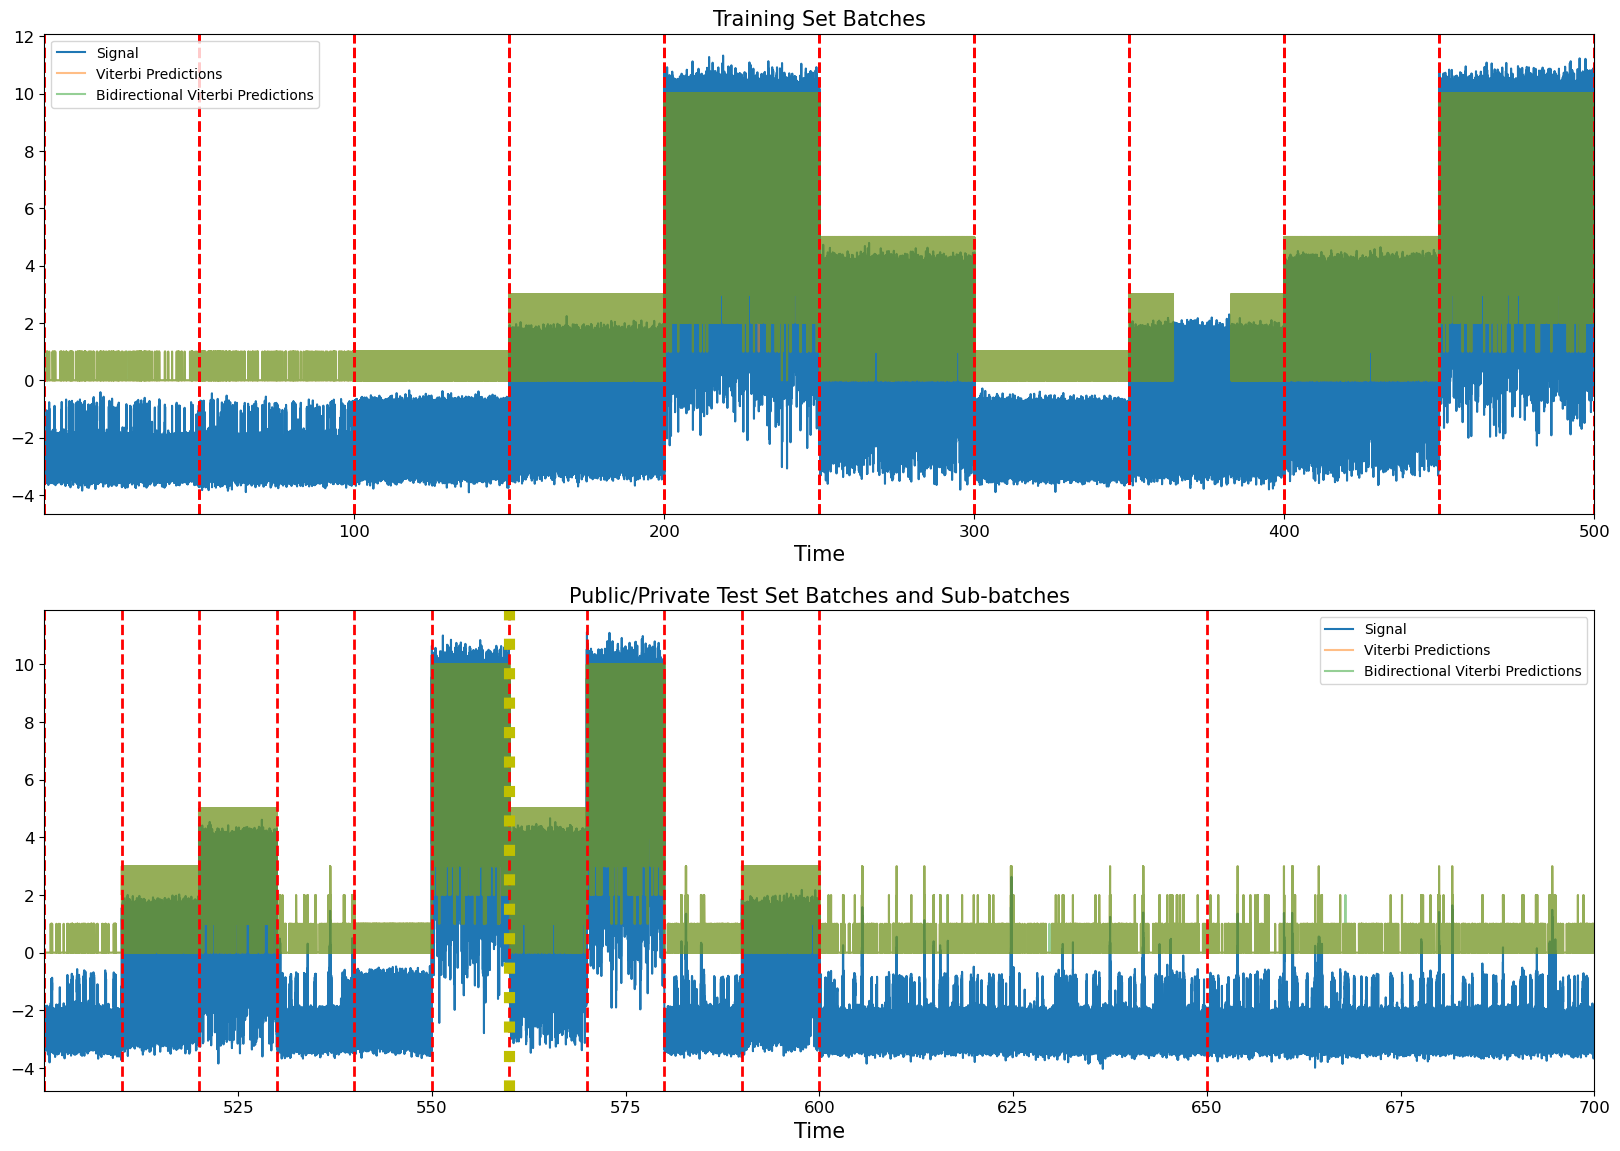

In [7]:
fig, axes = plt.subplots(nrows=2, figsize=(20, 14), dpi=100)

df_train.set_index('time')['signal_processed'].plot(label='Signal', ax=axes[0])
df_train.set_index('time')['final_viterbi_predictions'].plot(label='Viterbi Predictions', ax=axes[0], alpha=0.5)
df_train.set_index('time')['final_biviterbi_predictions'].plot(label='Bidirectional Viterbi Predictions', ax=axes[0], alpha=0.5)
for batch in np.arange(0, 550, 50):
    axes[0].axvline(batch, color='r', linestyle='--', lw=2)
    
df_test.set_index('time')['signal_processed'].plot(label='Signal', ax=axes[1])
df_test.set_index('time')['final_viterbi_predictions'].plot(label='Viterbi Predictions', ax=axes[1], alpha=0.5)
df_test.set_index('time')['final_biviterbi_predictions'].plot(label='Bidirectional Viterbi Predictions', ax=axes[1], alpha=0.5)

for batch in np.arange(500, 600, 10):
    axes[1].axvline(batch, color='r', linestyle='--', lw=2)
for batch in np.arange(600, 700, 50):
    axes[1].axvline(batch, color='r', linestyle='--', lw=2)
    
axes[1].axvline(560, color='y', linestyle='dotted', lw=8)

for i in range(2):    
    for batch in np.arange(0, 550, 50):
        axes[i].axvline(batch, color='r', linestyle='--', lw=2)
        
    axes[i].set_xlabel('Time', size=15)
    axes[i].tick_params(axis='x', labelsize=12)
    axes[i].tick_params(axis='y', labelsize=12)
    axes[i].legend()
    
axes[0].set_title('Training Set Batches', size=15)
axes[1].set_title('Public/Private Test Set Batches and Sub-batches', size=15)

plt.show()

In [8]:
df_train.to_pickle('train.pkl')
df_test.to_pickle('test.pkl')

submission = pd.read_csv('../input/liverpool-ion-switching/sample_submission.csv')
submission['open_channels'] = df_test['final_viterbi_predictions'].copy().astype(np.uint8)
submission.to_csv('onedirectionalviterbi_submission.csv', index=False, float_format='%.4f')
print(f'Submission One Directional Viterbi\n\n{submission["open_channels"].describe()}')

submission['open_channels'] = df_test['final_biviterbi_predictions'].copy().astype(np.uint8)
submission.to_csv('bidirectionalviterbi_submission.csv', index=False, float_format='%.4f')
print(f'\nSubmission Bidirectional Viterbi\n\n{submission["open_channels"].describe()}')

Submission One Directional Viterbi

count    2.000000e+06
mean     1.382028e+00
std      2.320712e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      1.000000e+01
Name: open_channels, dtype: float64

Submission Bidirectional Viterbi

count    2.000000e+06
mean     1.382030e+00
std      2.320703e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      2.000000e+00
max      1.000000e+01
Name: open_channels, dtype: float64
